# Определение возраста покупателей


Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройть модель, которая по фотографии определит приблизительный возраст человека. 

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, Flatten, Dense, 
                                     AvgPool2D, AveragePooling2D, GlobalAveragePooling2D)
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

In [2]:
sns.set_theme(style="whitegrid")
colors = sns.color_palette('deep')

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [4]:
labels.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [6]:
labels.describe().T


,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


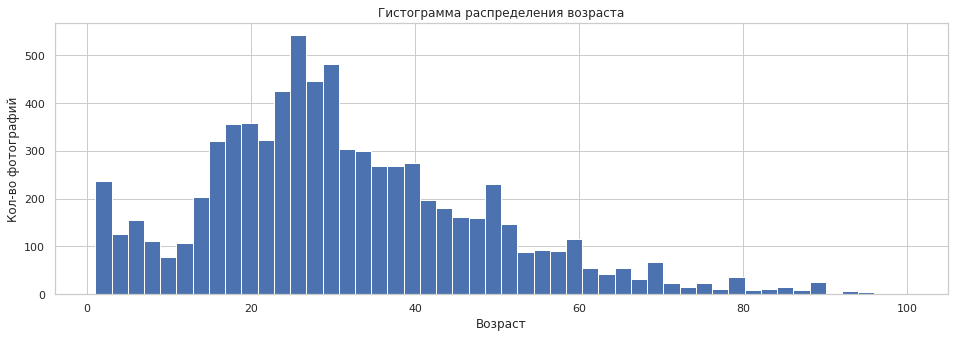

In [7]:
labels.hist(bins=50, figsize=(16,5))
plt.ylabel('Кол-во фотографий')
plt.xlabel('Возраст')
plt.title('Гистограмма распределения возраста');

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


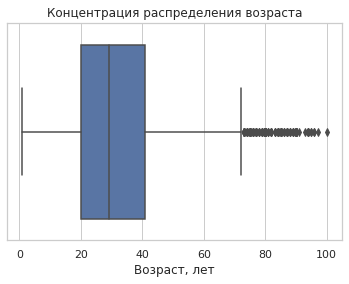

In [8]:
sns.boxplot(labels['real_age'])
plt.title('Концентрация распределения возраста')
plt.xlabel('Возраст, лет')
plt.show()

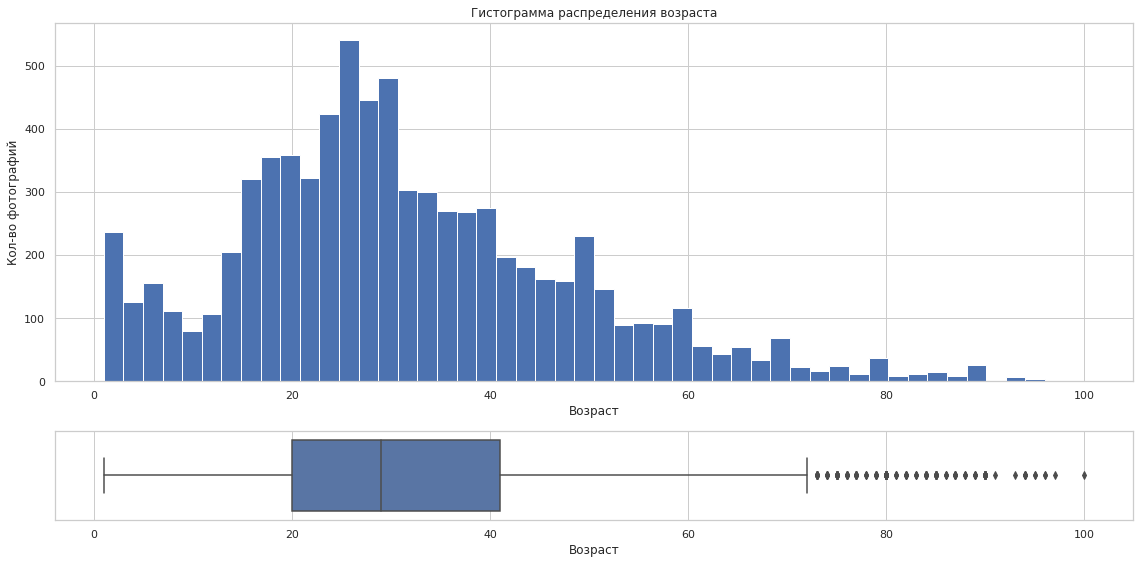

In [9]:

fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(16, 8), gridspec_kw={"height_ratios": (4, 1)})

ax_hist.hist(labels['real_age'], bins=50)
ax_hist.set_ylabel('Кол-во фотографий')
ax_hist.set_xlabel('Возраст')
ax_hist.set_title('Гистограмма распределения возраста')

sns.boxplot(x=labels['real_age'], ax=ax_box, orient='h')

ax_box.set_xlabel('Возраст')
ax_box.set_yticks([])  
plt.tight_layout()
plt.show()

In [10]:
%%time
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        class_mode='raw',
        shuffle=True,
        target_size=(224, 224),
        subset='training',
        batch_size=32,
        seed=12345)

Found 7591 validated image filenames.
CPU times: user 253 ms, sys: 171 ms, total: 424 ms
Wall time: 1min 23s


In [11]:
features, target = next(gen_flow)

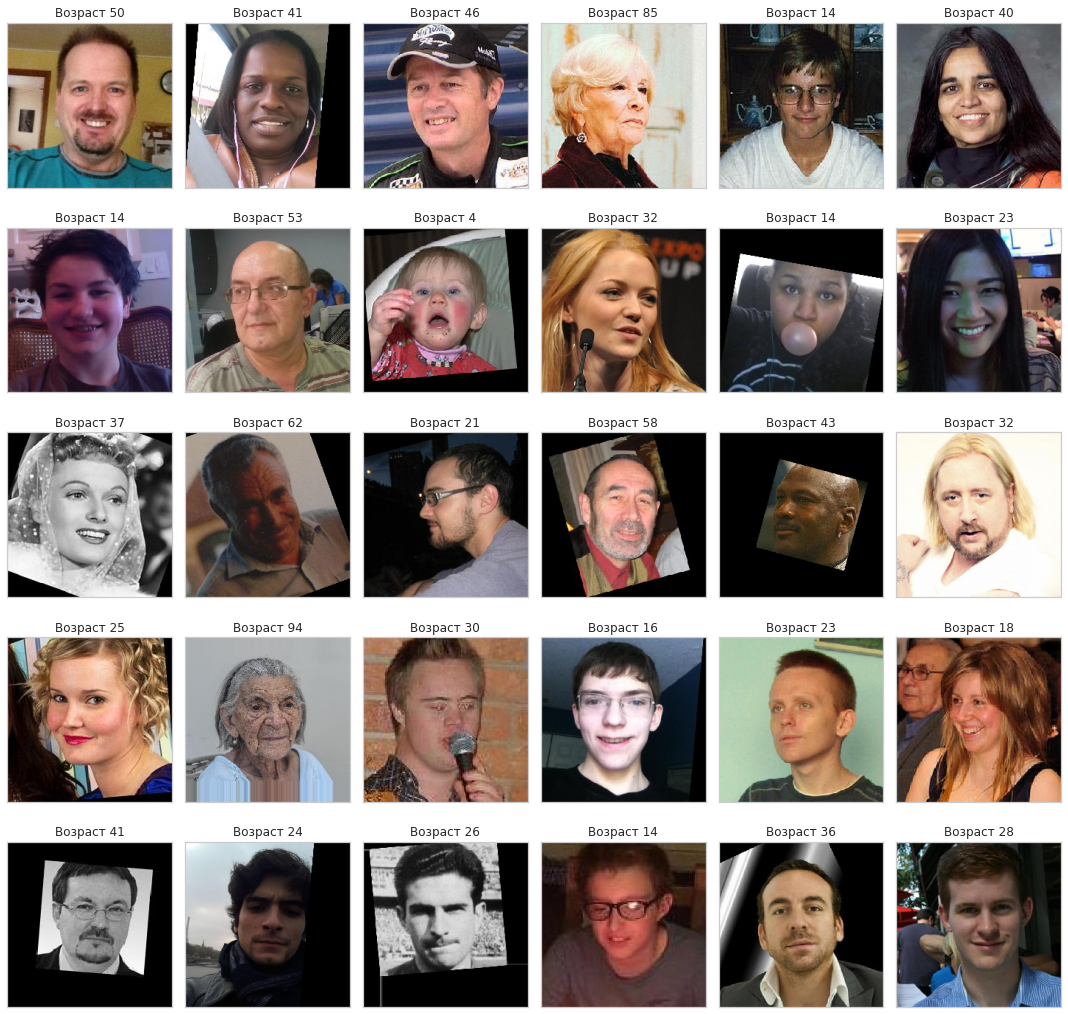

In [12]:
fig = plt.figure(figsize=(15,15))
for i in range(30):
    fig.add_subplot(5, 6, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст {target[i]}')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод

- В базе 7591 фотографий

- Большая часть возарста людей находится в диапазоне от 16 до 40 лет

- есть фото с лишними объектами перед лицом(жвачка, рука, микрофон и тд) 
- есть ЧБ фотографии, под углом, разных размеров

- В целом общая ориненатция фотографий выстроена правильно

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import seaborn as sns


def load_test(path):
    labels = pd.read_csv(path + "labels.csv")
    test_datagen = ImageDataGenerator(rescale=1.0 / 255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        seed=12345,
    )
    return test_datagen_flow


def load_train(path):
    labels = pd.read_csv(path + "labels.csv")
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        validation_split=0.25,
        horizontal_flip=True,
        brightness_range=(0.8, 1.0),
    )

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + "final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224, 224),
        batch_size=32,
        class_mode="raw",
        subset="training",
        seed=12345,
    )
    return train_datagen_flow


def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, weights="imagenet", include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation="relu"))
    optimizer = Adam(lr=0.0003)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    return model


def train_model(
    model,
    train_data,
    test_data,
    batch_size=None,
    epochs=10,
    steps_per_epoch=None,
    validation_steps=None,
):

    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
    )

    return model


```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-07-10 19:25:40.874414: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-10 19:25:41.203753: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 61s - loss: 199.3295 - mae: 10.3355 - val_loss: 467.4146 - val_mae: 16.5318
Epoch 2/10
178/178 - 51s - loss: 96.7679 - mae: 7.4286 - val_loss: 651.7647 - val_mae: 20.5217
Epoch 3/10
178/178 - 52s - loss: 69.1557 - mae: 6.2766 - val_loss: 437.6701 - val_mae: 15.9991
Epoch 4/10
178/178 - 51s - loss: 53.1999 - mae: 5.5644 - val_loss: 169.1258 - val_mae: 9.9005
Epoch 5/10
178/178 - 51s - loss: 37.7634 - mae: 4.7383 - val_loss: 197.2420 - val_mae: 11.2054
Epoch 6/10
178/178 - 51s - loss: 33.0668 - mae: 4.3762 - val_loss: 134.3136 - val_mae: 9.0559
Epoch 7/10
178/178 - 51s - loss: 28.3211 - mae: 4.0480 - val_loss: 107.0455 - val_mae: 7.5042
Epoch 8/10
178/178 - 52s - loss: 22.3162 - mae: 3.6300 - val_loss: 76.7910 - val_mae: 6.6714
Epoch 9/10
178/178 - 51s - loss: 18.0822 - mae: 3.2572 - val_loss: 101.4225 - val_mae: 7.4535
Epoch 10/10
178/178 - 51s - loss: 15.1312 - mae: 2.9667 - val_loss: 70.8874 - val_mae: 6.2720
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 70.8874 - mae: 6.2720
Test MAE: 6.2720

```

In [14]:
# import pandas as pd
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import MobileNetV2
# import matplotlib.pyplot as plt

# def load_test(path):
#     labels = pd.read_csv(path + 'labels.csv')
#     test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
#     test_datagen_flow = test_datagen.flow_from_dataframe(
#         dataframe=labels,
#         directory=path + 'final_files/',
#         x_col='file_name',
#         y_col='real_age',
#         target_size=(224, 224),  # уменьшенный размер изображения
#         batch_size=16,  # уменьшенный размер batch
#         class_mode='raw',
#         subset='validation',
#         seed=12345
#     )
#     return test_datagen_flow

# def load_train(path):
#     labels = pd.read_csv(path + 'labels.csv')
#     train_datagen = ImageDataGenerator(
#         rescale=1./255,
#         validation_split=0.25,
#         horizontal_flip=True,
#         brightness_range=(0.8, 1.)
#     )
#     train_datagen_flow = train_datagen.flow_from_dataframe(
#         dataframe=labels,
#         directory=path + 'final_files/',
#         x_col='file_name',
#         y_col='real_age',
#         target_size=(128, 128),  # уменьшенный размер изображения
#         batch_size=16,  # уменьшенный размер batch
#         class_mode='raw',
#         subset='training',
#         seed=12345
#     )
#     return train_datagen_flow

# def create_model(input_shape):
#     backbone = MobileNetV2(input_shape=input_shape, weights='imagenet', include_top=False)
#     model = Sequential()
#     model.add(backbone)
#     model.add(GlobalAveragePooling2D())
#     model.add(Dense(1, activation='relu'))
#     optimizer = Adam(lr=0.0003)
#     model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
#     return model

# def train_model(model, train_data, test_data, batch_size=None, epochs=30, steps_per_epoch=None, validation_steps=None):
#     model.fit(
#         train_data,
#         validation_data=test_data,
#         batch_size=batch_size,
#         epochs=epochs,
#         steps_per_epoch=steps_per_epoch,
#         validation_steps=validation_steps,
#         verbose=2
#     )
#     return model

# # Путь к данным
# path = '/datasets/faces/'

# # Загрузка данных
# train_data = load_train(path)
# test_data = load_test(path)

# # Создание модели
# input_shape = (224, 224, 3)
# model = create_model(input_shape)

# # Обучение модели
# model = train_model(
#     model,
#     train_data,
#     test_data,
#     steps_per_epoch=10,  # ограниченное количество шагов
#     validation_steps=10,  # ограниченное количество шагов
#     epochs=30
# )


## Анализ обученной модели

В нашем распоряжении был датасет из 7591 размеченной фотографии, где преобладали изображения с низким освещением и горизонтальным вращением.

Для оптимизации модели мы использовали алгоритм Adam с шагом обучения 0.003 и функцию потерь mean_squared_error (mse). На тестовом наборе данных модель достигла MAE 6.0624 уже после 8 эпох обучения, что соответствует нашей цели. 

Несмотря на относительно небольшой размер выборки, время обучения было оптимизировано эффективно.

Использование GPU и современных нейронных сетей позволяет обрабатывать большие объемы данных с высокой точностью и скоростью.

Погрешность в 6 лет не является значительной для большинства случаев определения возраста, за исключением задач, связанных с продажей алкоголя.

Полученная модель способна эффективно решать поставленные бизнесом задачи, однако всегда есть потенциал для улучшения.